# Titanic: Machine Learning from Disaster

Author: Jingwen ZHENG<br>
Update: 2019-05-05

## Content
- Project understanding
- Objectif
- Practice skills
- Python packages to be applied
- Import data
- Data description
- Data cleaning
- Data analysis
- Build preprocessing pipeline
- Train data
- Reference

## Project understanding

The sinking of the RMS Titanic is one of the most infamous shipwrecks in history.  On April 15, 1912, during her maiden voyage, the Titanic sank after colliding with an iceberg, killing 1502 out of 2224 passengers and crew. This sensational tragedy shocked the international community and led to better safety regulations for ships.

One of the reasons that the shipwreck led to such loss of life was that there were not enough lifeboats for the passengers and crew. Although there was some element of luck involved in surviving the sinking, some groups of people were more likely to survive than others, such as women, children, and the upper-class.

## Objectif

In this challenge, we need to analyse what sorts of people were likely to survive.<br>
In particular, we also need to apply the tools of machine learning to predict which passengers survived the tragedy.

## Practice Skills

- Python 3
- Binary classification

## Python packages to be applied

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import mean_squared_error
from scipy.stats import reciprocal, uniform

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier


## Import data

In [2]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [3]:
print('Dimension train_df:', train_df.shape)
print('Dimension test_df:', test_df.shape)

Dimension train_df: (891, 12)
Dimension test_df: (418, 11)


In [4]:
train_df.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [5]:
test_df.head(3)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q


## Data description

In [6]:
train_df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
PassengerId,891,NaN,NaN,NaN,446,257.354,1,223.5,446,668.5,891
Survived,891,NaN,NaN,NaN,0.383838,0.486592,0,0,0,1,1
Pclass,891,NaN,NaN,NaN,2.30864,0.836071,1,2,3,3,3
Name,891,891,"Olsvigen, Mr. Thor Anderson",1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Sex,891,2,male,577,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Age,714,NaN,NaN,NaN,29.6991,14.5265,0.42,20.125,28,38,80
SibSp,891,NaN,NaN,NaN,0.523008,1.10274,0,0,0,1,8
Parch,891,NaN,NaN,NaN,0.381594,0.806057,0,0,0,0,6
Ticket,891,681,1601,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Fare,891,NaN,NaN,NaN,32.2042,49.6934,0,7.9104,14.4542,31,512.329


In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


## Data cleaning

=> There are missing data in "Age", "Cabin" and "Embarked", especially "Cabin" whose 77% data are missing. So we will ignore it during the analysis.<br>
What should we do on missing data of "Age"? We might replace null by median age.<br>
Same for "Embarked"<br>
=> On average, the probability of one passenger being survived is 38%.

In [8]:
train_df['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [9]:
train_df['Age'].fillna(train_df['Age'].median(), inplace=True)
train_df['Embarked'].fillna('S', inplace=True)

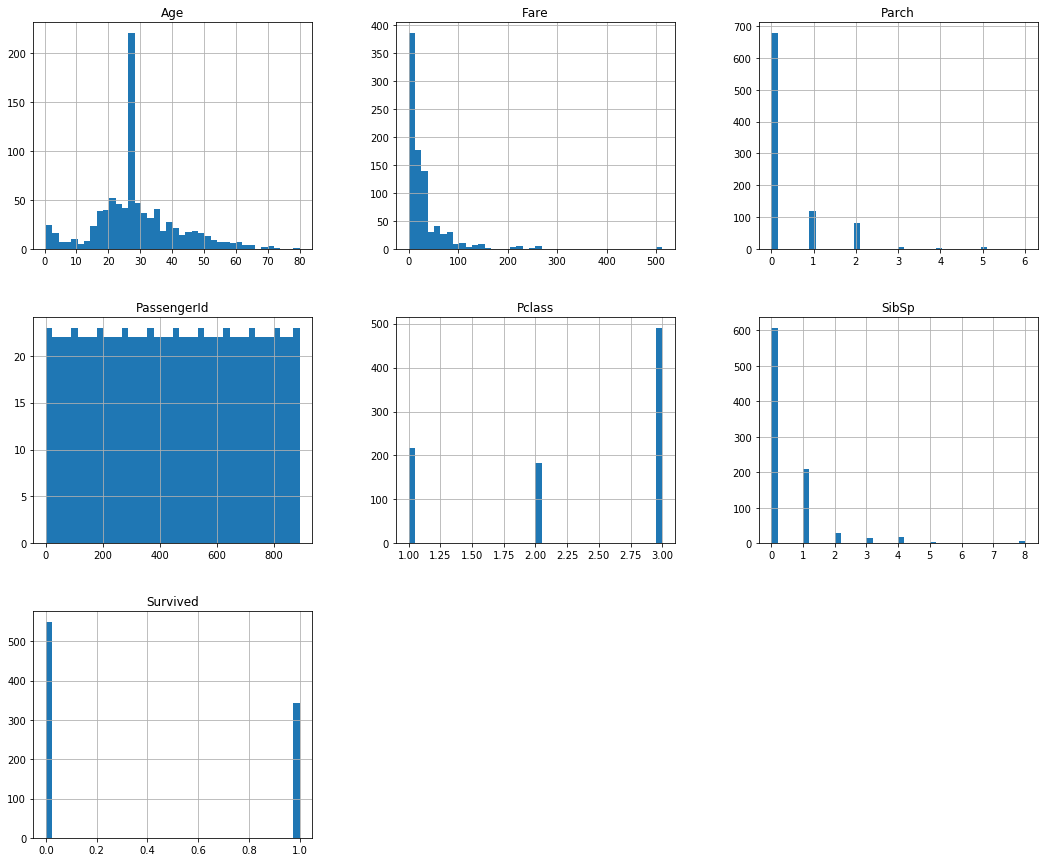

In [10]:
train_df.hist(bins=40, figsize=(18, 15))
plt.show()

## Data analysis

### Correlation matrix between numerical values and "Survived"

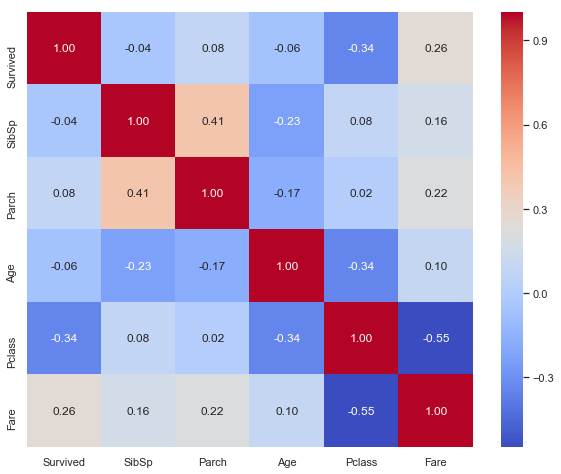

In [11]:
sns.set(rc={'figure.figsize':(10, 8)})

sns.heatmap(train_df[['Survived', 'SibSp', 'Parch', 'Age', 'Pclass', 'Fare']].corr(),
            annot=True,
            fmt='.2f',
            cmap='coolwarm')
plt.show()

According to this correlation heatmap, we find that "Survived" possibility is slightly negative correlated with "Age", which means that the older the passenger is, the more possible he will be survived; it's significant at 5%. "Pclass" and "Fare are negatively correlated which is logic: the better class is, the more expensive fare is. "Pclass" is also negative correlated with "Survived" possibility, maybe the top class's location is nearer to exit?

### SibSp vs. Survived

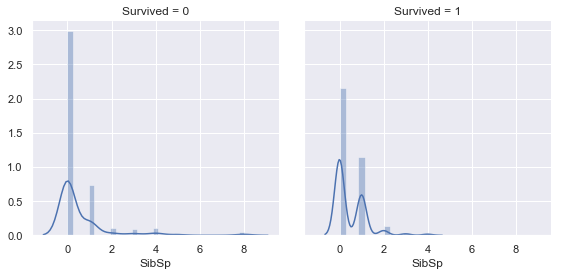

In [12]:
sibsp_survived_plt = sns.FacetGrid(train_df, col='Survived', height=4, aspect=1)
sibsp_survived_plt.map(sns.distplot, 'SibSp')

plt.show()

Most of survived people didn't have siblings / spouses aboard the Titanic, other survived majority is people who had one sibling / spouse aboard the Titanic. Very few people who had more than one sibling / spouse aboard the Titanic were survived, since it's difficult to survive all passengers.

/usr/local/lib/python3.7/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.7/site-packages/seaborn/categorical.py:3672: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


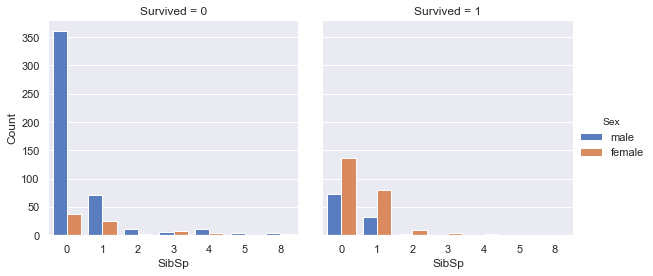

In [13]:
sibsp_sex_survived_plt = sns.factorplot(x='SibSp',
                                        col='Survived',
                                        data=train_df,
                                        hue='Sex',
                                        kind='count',
                                        palette='muted',
                                        size=4,
                                        aspect=1)
sibsp_sex_survived_plt.despine(left=True)
sibsp_sex_survived_plt.set_ylabels('Count')

plt.show()

Among all survivals, the majority was female.

### Parch vs. Survived

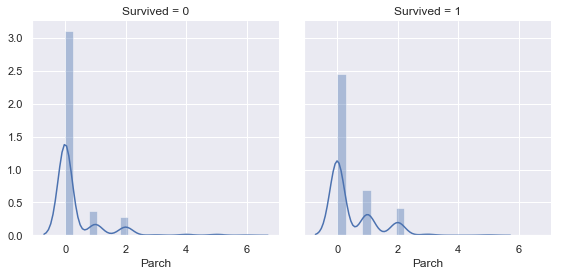

In [14]:
parch_survived_plt = sns.FacetGrid(train_df, col='Survived', height=4, aspect=1)
parch_survived_plt.map(sns.distplot, 'Parch')

plt.show()

Similarly as relation between SibSp vs. Survived, most of survived people didn't have parents / children aboard the Titanic, other survived majority is people who had one parent / child aboard the Titanic. Very few people who had more than one parent / child aboard the Titanic were survived, since it's difficult to survive all passengers.

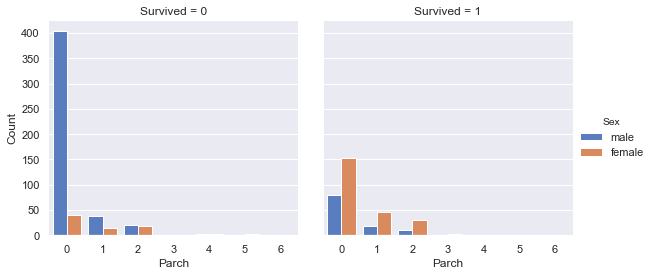

In [15]:
parch_sex_survived_plt = sns.factorplot(x='Parch',
                                        col='Survived',
                                        data=train_df,
                                        hue='Sex',
                                        kind='count',
                                        palette='muted',
                                        size=4,
                                        aspect=1)
parch_sex_survived_plt.despine(left=True)
parch_sex_survived_plt.set_ylabels('Count')

plt.show()

Among all survivals, the majority was female.

### Age vs. Survived

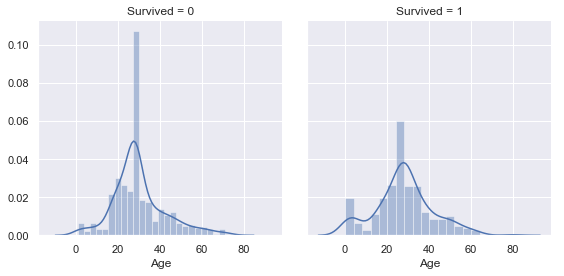

In [16]:
age_survived_plt = sns.FacetGrid(train_df, col='Survived', height=4, aspect=1)
age_survived_plt.map(sns.distplot, 'Age')

plt.show()

"Age" distribution is nearly a Normal distribution. We find that the most survived are the people around 25 year-old, which might because there were lots of younger on the board. However, people older than 50 year-old is less survived, which is not extractly same as analysis above. The graph below will explain why.

### Age vs. Sex vs. Survived

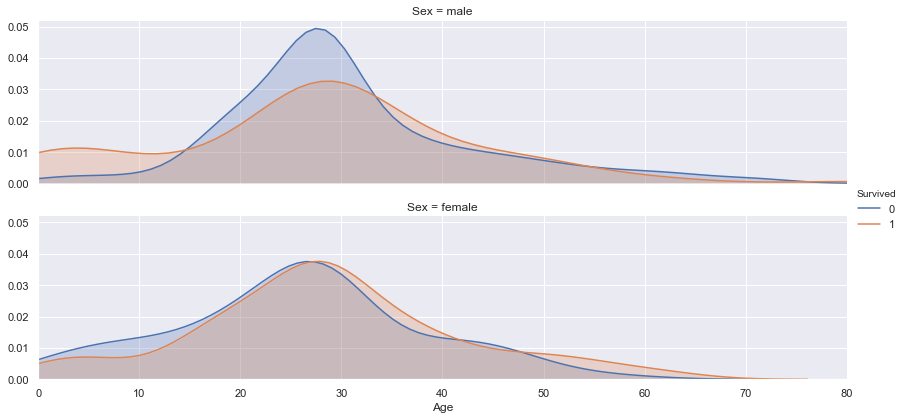

In [17]:
age_sex_survived_plt = sns.FacetGrid(train_df , hue='Survived' , aspect=4 , row = 'Sex' )
age_sex_survived_plt.map( sns.kdeplot, 'Age' , shade= True )
age_sex_survived_plt.set( xlim=( 0 , train_df['Age'].max() ) )
age_sex_survived_plt.add_legend()
plt.show()

In [18]:
train_df[(train_df['Survived']==0) & (train_df['Age']>50)].Sex.value_counts()

male      41
female     1
Name: Sex, dtype: int64

In [19]:
train_df[(train_df['Survived']==1) & (train_df['Age']>50)].Sex.value_counts()

female    16
male       6
Name: Sex, dtype: int64

According to this plot, we find that both female and male passengers are nearly half survived, since the shadow surface of "Survived" and "Non-survived" are nearly the same. But the survived possibility is different on ages for female and male. For female passengers, the ones that older than 27 year-old have a little bit more chance to be survived than others. For male passengers, the one who is younger than 15 years old or older than 34 years old are more likely to be survived than men between 16 and 32 years old, which because they help other passengers to be alive.<br>
Moreover, let's pay attention to the passengers that were older than 50 year-old. According to the graph "Age vs. Survived" we find that people older than 50 year-old is less survived, which is not extractly same as correlation analysis. But from this graph we can easily understand why: most of older _passengers_ were male, most of the older _survival_ were female, and they were nearly all survived. So in fact, older female passengers had much more chance to be survived than older male passengers.

### Pclass vs. Survived

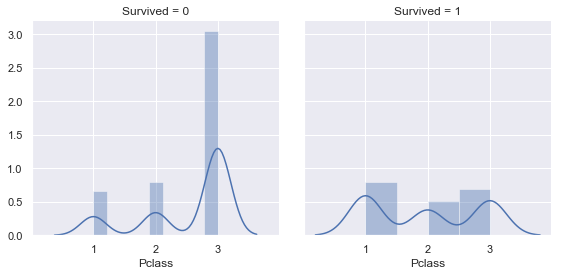

In [20]:
pclass_survived_plt = sns.FacetGrid(train_df, col='Survived', height=4, aspect=1)
pclass_survived_plt.map(sns.distplot, 'Pclass')

plt.show()

For the class of survived passengers, it's almost same for each class, the possibility for class 1 is a bit more higher than others. However, non-survived probability of class 3 is 3 times of class 1 and class 2, respectively. This is coherent with analysis above.

### Embarked vs. Survived

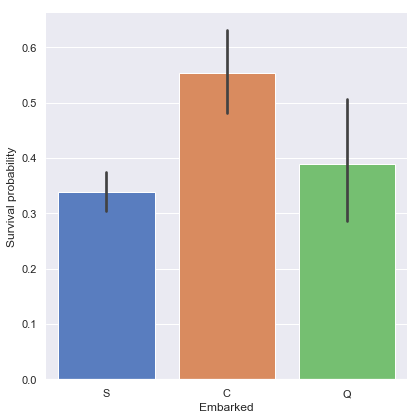

In [21]:
embarked_survived_plt = sns.factorplot(data=train_df,
                                       x='Embarked',
                                       y='Survived',
                                       size=6,
                                       kind='bar',
                                       palette='muted')
embarked_survived_plt.despine(left=True)
embarked_survived_plt.set_ylabels('Survival probability')

plt.show()

Passengers who came from Cherbourg (`Embarked='C'`) had more chance to be survived, so we'll study why they were most survived in the following.

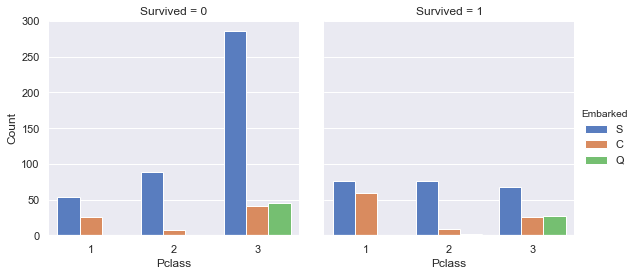

In [22]:
pclass_embarked_survived_plt = sns.factorplot(x='Pclass',
                                              col='Survived',
                                              data=train_df,
                                              hue='Embarked',
                                              kind='count',
                                              palette='muted',
                                              size=4,
                                              aspect=1)
pclass_embarked_survived_plt.despine(left=True)
pclass_embarked_survived_plt.set_ylabels('Count')

plt.show()

According to this graph, we find that the majority of passengers came from Southampton (`Embarked='S'`) and lots of them chose class 3 which decrease the survived chance. However, the marjority of passengers who came from Cherbourg (`Embarked='C'`) were in class 1, such their chance to be survived was more than others, which is coherent with result above.

## Build preprocessing pipeline
Inspired by https://github.com/ageron/handson-ml/blob/master/03_classification.ipynb

In [23]:
# A class to select numerical or categorical columns 
# since Scikit-Learn doesn't handle DataFrames yet
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names]

In [24]:
num_attribs = ['Age', 'SibSp', 'Parch', 'Fare']
cat_attribs = ['Pclass', 'Sex', 'Embarked']

### Build pipeline for numeric variables

In [25]:
num_pipeline = Pipeline([
    ('select_numeric', DataFrameSelector(num_attribs)),
    ('imputer', SimpleImputer(strategy='median'))
])

In [26]:
num_pipeline.fit_transform(train_df)

array([[22.    ,  1.    ,  0.    ,  7.25  ],
       [38.    ,  1.    ,  0.    , 71.2833],
       [26.    ,  0.    ,  0.    ,  7.925 ],
       ...,
       [28.    ,  1.    ,  2.    , 23.45  ],
       [26.    ,  0.    ,  0.    , 30.    ],
       [32.    ,  0.    ,  0.    ,  7.75  ]])

### Build pipeline for categorical variables

In [27]:
class MostFrequentImputer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.most_frequent_ = pd.Series([X[c].value_counts().index[0] for c in X],
                                        index=X.columns)
        return self
    def transform(self, X, y=None):
        return X.fillna(self.most_frequent_)

In [28]:
cat_pipeline = Pipeline([
    ('select_numeric', DataFrameSelector(cat_attribs)),
    ('imputer', MostFrequentImputer()),
    ('cat_encoder', OneHotEncoder(sparse=False)) # return an array
])

In [29]:
cat_pipeline.fit_transform(train_df)

array([[0., 0., 1., ..., 0., 0., 1.],
       [1., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 0., 1.],
       ...,
       [0., 0., 1., ..., 0., 0., 1.],
       [1., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 1., 0.]])

### Join 2 pipelines into a single pipeline

In [30]:
full_pipeline = FeatureUnion(transformer_list=[('num_pipeline', num_pipeline),
                                               ('cat_pipeline', cat_pipeline)]
                            )

In [31]:
X_train = full_pipeline.fit_transform(train_df)
X_train

array([[22.,  1.,  0., ...,  0.,  0.,  1.],
       [38.,  1.,  0., ...,  1.,  0.,  0.],
       [26.,  0.,  0., ...,  0.,  0.,  1.],
       ...,
       [28.,  1.,  2., ...,  0.,  0.,  1.],
       [26.,  0.,  0., ...,  1.,  0.,  0.],
       [32.,  0.,  0., ...,  0.,  1.,  0.]])

In [32]:
y_train = train_df['Survived']

In [33]:
X_test = full_pipeline.fit_transform(test_df)
X_test

array([[34.5,  0. ,  0. , ...,  0. ,  1. ,  0. ],
       [47. ,  1. ,  0. , ...,  0. ,  0. ,  1. ],
       [62. ,  0. ,  0. , ...,  0. ,  1. ,  0. ],
       ...,
       [38.5,  0. ,  0. , ...,  0. ,  0. ,  1. ],
       [27. ,  0. ,  0. , ...,  0. ,  0. ,  1. ],
       [27. ,  1. ,  1. , ...,  1. ,  0. ,  0. ]])

## Train a classifier

In [34]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

### SVM (Support-vector machine)

In [35]:
svr_params = {'C': uniform(1, 10)}
svr_rnd_search_cv = RandomizedSearchCV(SVC(gamma='auto', random_state=42),
                                       svr_params,
                                       n_iter=10,
                                       cv=3,
                                       n_jobs=-1)
svr_rnd_search_cv.fit(X_train_scaled, y_train)

RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=42, shrinking=True,
  tol=0.001, verbose=False),
          fit_params=None, iid='warn', n_iter=10, n_jobs=-1,
          param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x12382d400>},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=0)

In [36]:
y_pred_svr = svr_rnd_search_cv.best_estimator_.predict(X_train_scaled)
mse_svr = mean_squared_error(y_train, y_pred_svr)
np.sqrt(mse_svr)

0.40201512610368484

### Decision Trees

In [37]:
decisionTree_params = {'max_leaf_nodes': list(range(2, 100)), 'min_samples_split': [2, 3, 4]}
decisionTree_rnd_search_cv = RandomizedSearchCV(DecisionTreeClassifier(random_state=42),
                                                decisionTree_params,
                                                cv=3,
                                                n_jobs=-1)
decisionTree_rnd_search_cv.fit(X_train_scaled, y_train)

RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best'),
          fit_params=None, iid='warn', n_iter=10, n_jobs=-1,
          param_distributions={'max_leaf_nodes': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99], 'min_samples_split': [2, 3, 4]},
          pre_dispatch='2*n_jobs', random_st

In [38]:
y_pred_decisionTree = decisionTree_rnd_search_cv.best_estimator_.predict(X_train_scaled)
mse_decisionTree = mean_squared_error(y_train, y_pred_decisionTree)
np.sqrt(mse_decisionTree)

0.30704412431455885

### Random Forest

In [39]:
rdmFrst_params = {'n_estimators': list(range(100, 1000, 100))}
rdmFrst_rnd_search_cv = RandomizedSearchCV(RandomForestClassifier(random_state=42),
                                           rdmFrst_params,
                                           cv=3,
                                           n_jobs=-1)
rdmFrst_rnd_search_cv.fit(X_train_scaled, y_train)

/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_search.py:271: UserWarning: The total space of parameters 9 is smaller than n_iter=10. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=10, n_jobs=-1,
          param_distributions={'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=0)

In [40]:
y_pred_rdmFrst = rdmFrst_rnd_search_cv.best_estimator_.predict(X_train_scaled)
mse_rdmFrst = mean_squared_error(y_train, y_pred_rdmFrst)
np.sqrt(mse_rdmFrst)

0.1421338109037403

### Logistic Regression

In [41]:
log_reg = LogisticRegression()
log_reg.fit(X_train_scaled, y_train)

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [42]:
y_pred_logReg = log_reg.predict(X_train_scaled)
mse_logReg = mean_squared_error(y_train, y_pred_logReg)
np.sqrt(mse_logReg)

0.4419119768530779

### Compare different models' root MSE

In [43]:
root_mse_df = pd.DataFrame({'Models': ['SVM',
                                       'Decision Trees',
                                       'Random Forest',
                                       'Logistic Regression'],
                            'Root_MSE': [np.sqrt(mse_svr),
                                         np.sqrt(mse_decisionTree),
                                         np.sqrt(mse_rdmFrst),
                                         np.sqrt(mse_logReg)]},
                           columns=['Models', 'Root_MSE'])
root_mse_df.sort_values('Root_MSE', inplace=True, ascending=False)
root_mse_df.reset_index(inplace=True, drop=True)

In [44]:
root_mse_df

,Models,Root_MSE
0,Logistic Regression,0.441912
1,SVM,0.402015
2,Decision Trees,0.307044
3,Random Forest,0.142134


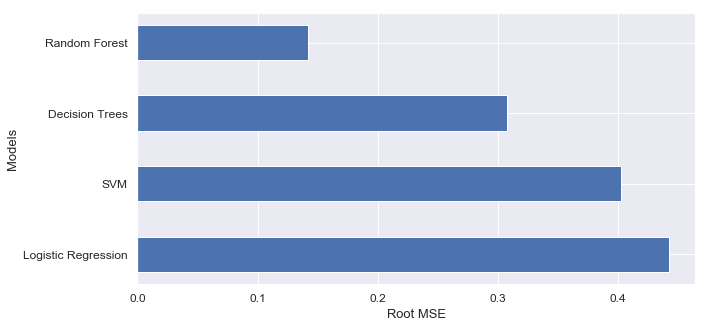

In [45]:
plt.figure(figsize=(10, 5))
plt.barh(np.arange(len(root_mse_df['Models'])), root_mse_df['Root_MSE'], align='center', height=0.5)

plt.yticks(np.arange(len(root_mse_df['Models'])), root_mse_df['Models'])
plt.tick_params(labelsize=12)
plt.xlabel('Root MSE', fontdict={'fontsize': 13})
plt.ylabel('Models', fontdict={'fontsize': 13})

plt.show()

### Compare different models' best_score_

In [46]:
best_score_df = pd.DataFrame({'Models': ['SVM',
                                         'Decision Trees',
                                         'Random Forest'],
                              'best_score_': [svr_rnd_search_cv.best_score_,
                                              decisionTree_rnd_search_cv.best_score_,
                                              rdmFrst_rnd_search_cv.best_score_]},
                             columns=['Models', 'best_score_'])
best_score_df.sort_values('best_score_', inplace=True, ascending=False)
best_score_df.reset_index(inplace=True, drop=True)

In [47]:
best_score_df

,Models,best_score_
0,SVM,0.828283
1,Decision Trees,0.820426
2,Random Forest,0.796857


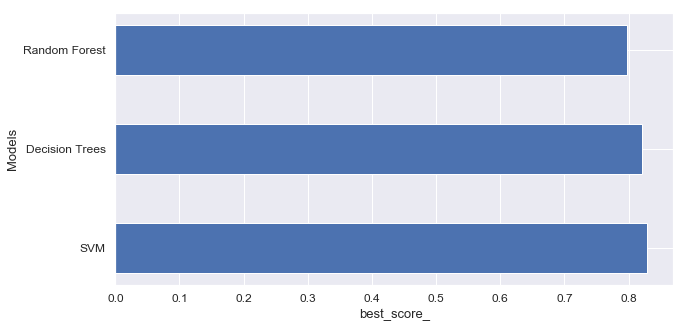

In [48]:
plt.figure(figsize=(10, 5))
plt.barh(np.arange(len(best_score_df['Models'])), best_score_df['best_score_'], align='center', height=0.5)

plt.yticks(np.arange(len(best_score_df['Models'])), best_score_df['Models'])
plt.tick_params(labelsize=12)
plt.xlabel('best_score_', fontdict={'fontsize': 13})
plt.ylabel('Models', fontdict={'fontsize': 13})

plt.show()

## Prediction with test data

Since the root MSE of Random Forest model is the least among four models that we chose, I'll apply Random Forest to predict survivals in test dataset.

In [49]:
y_test = rdmFrst_rnd_search_cv.best_estimator_.predict(X_test)

In [50]:
passengerID_test = test_df['PassengerId']
output_df = pd.DataFrame({'PassengerId':passengerID_test,
                          'Survived': y_test},
                         columns=['PassengerId', 'Survived'])

In [51]:
output_df.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0


In [52]:
len(output_df)

418

In [53]:
output_df.to_csv('titanic_predict_survivals.csv', index=False)

## Reference

- Kaggle Competition: [Titanic: Machine Learning from Disaster](https://www.kaggle.com/c/titanic/overview)
- [Introduction to Ensembling/Stacking in Python](https://www.kaggle.com/arthurtok/introduction-to-ensembling-stacking-in-python)
- [Titanic Top 4% with ensemble modeling](https://www.kaggle.com/yassineghouzam/titanic-top-4-with-ensemble-modeling)
- [An Interactive Data Science Tutorial](https://www.kaggle.com/helgejo/an-interactive-data-science-tutorial)
- [handson-ml/03_classification.ipynb](https://github.com/ageron/handson-ml/blob/master/03_classification.ipynb)